In [3]:
import cv2
import numpy as np
import scipy.io as sio
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import sys
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

In [8]:
def find_match(img1, img2):
    # TO DO
    sift1 = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift1.detectAndCompute(img1,None)

    sift2 = cv2.xfeatures2d.SIFT_create()
    kp2, des2 = sift2.detectAndCompute(img2,None)
    
    nbrs = NearestNeighbors(algorithm='auto').fit(des2)
    
    distances, indices =nbrs.kneighbors(des1,n_neighbors=2)
    
    nbrs_2 = NearestNeighbors(algorithm='auto').fit(des1)
    
    distances_2, indices_2 =nbrs_2.kneighbors(des2,n_neighbors=2)
    
    x1_12 = np.empty((0,2))
    x2_12 = np.empty((0,2))
    
    for i in range(len(distances)):
        if (distances[i,0]/distances[i,1])<0.7:
            x1_12 = np.append(x1_12, kp1[i].pt)
            x2_12 = np.append(x2_12, kp2[indices[i,0]].pt)
            
    x1_12 = x1_12.reshape(len(x1_12)//2,2)
    x2_12 = x2_12.reshape(len(x2_12)//2,2)

    
    x1_21 = np.empty((0,2))
    x2_21 = np.empty((0,2))
    
    for i in range(len(distances_2)):
        if (distances_2[i,0]/distances_2[i,1])<0.7:
            x2_21 = np.append(x2_21, kp2[i].pt)
            x1_21 = np.append(x1_21, kp1[indices_2[i,0]].pt)
    
    x1_21 = x1_21.reshape(len(x1_21)//2,2)
    x2_21 = x2_21.reshape(len(x2_21)//2,2)
    
    set_1 =  np.concatenate((x1_12, x2_12), axis=1)
    set_2 =  np.concatenate((x1_21, x2_21), axis=1)
    
    set_1_v = set_1.view([('', set_1.dtype)] * set_1.shape[1]).ravel()
    set_2_v = set_2.view([('', set_2.dtype)] * set_2.shape[1]).ravel()
    final_p = np.intersect1d(set_1_v, set_2_v).view(set_1.dtype).reshape(-1, set_1.shape[1])
    
    pts1 = final_p[:,0:2]
    pts2 = final_p[:,2:]

    
    return pts1, pts2

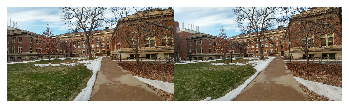

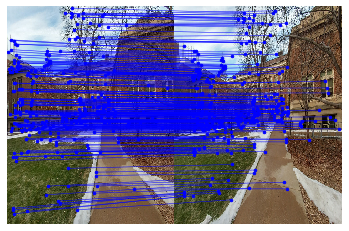

In [9]:
img_left = cv2.imread('./left.bmp', 1)
img_right = cv2.imread('./right.bmp', 1)
visualize_img_pair(img_left, img_right)

# Step 1: find correspondences between image pair
pts1, pts2 = find_match(img_left, img_right)
visualize_find_match(img_left, img_right, pts1, pts2)

In [10]:
A = np.array([[1,2,3],[2,5,6],[2,4,6]])
#A = np.random.rand(3,3)

print(A)
u, s, vh = np.linalg.svd(A,full_matrices=False)
print(s)
print(vh)
v= vh.T
f = v[:, -1]
print(f)
A@f

[[1 2 3]
 [2 5 6]
 [2 4 6]]
[1.16029569e+01 6.09419469e-01 1.04487240e-17]
[[-2.58377390e-01 -5.76551162e-01 -7.75132171e-01]
 [ 1.82321486e-01 -8.17061049e-01  5.46964458e-01]
 [ 9.48683298e-01  5.55111512e-17 -3.16227766e-01]]
[ 9.48683298e-01  5.55111512e-17 -3.16227766e-01]


array([0., 0., 0.])

In [11]:
1 or 0


1

In [295]:
def compute_F(pts1, pts2):
    # TO DO
    sample_num = len(pts1)
    inlier_record = 0
    inlierThresh = 0.73
    ransac_iter = 60
    threshold = 5
    draw_num = 8
    
    
    #W = @(ux, uy, vx, vy) [ux*vx, uy*vx, vx, ux*vy, uy* vy, vy, ux, uy, 1];
    
    i = 0 
    count = 0
    while ((i <= ransac_iter) and (count <= 2e4)):
        i = 0
        if inlier_record/sample_num > inlierThresh:
            i = i+1
            if i%10 ==0 :
                print(i)
        count = count + 1
        if count%100 ==0:
            print(count)
            
        draw = np.random.choice(sample_num, draw_num,replace=False)
        pts1_draw = pts1[draw, :]
        pts2_draw = pts2[draw, :]
        
        
        A = []
        # generate matrix A for A * F = 0 
        
        for j in range(draw_num):
            temp = np.outer(np.append(pts2_draw[j],1),np.append(pts1_draw[j],1))
            A.append(np.reshape(temp,np.size(temp) )) 
        
        A = np.reshape(A,(draw_num,np.size(temp)))
        #[u,d,v] = svd(A)
        
        
        u, s, vh = np.linalg.svd(A)
        
        v= vh.T
        
        f = v[:, -1].reshape((3,3))
        
        #f = [f(1:3), f(4:6), f(7:9)]

        [U,D,VH] =  np.linalg.svd(f)
        #print(s[-1],A@v[:, -1],D)
        D[-1] = 0
        #print(D)
        F_temp = U @ np.diag(D) @ VH.T
        
        numInlier = 0
        for k in range(sample_num):
            L = F_temp @ (np.append(pts1[k,:],1)).reshape(3,1)
            #print(L)
            #print(np.append(pts2[k,:],1) @ L)
            
            d = abs(np.append(pts2[k,:],1) @ L)/np.sqrt(L[0]**2 + L[1]**2)
            if d <= threshold:
                numInlier = numInlier +1

        
        if numInlier > inlier_record:
            inlier_record = numInlier
            F = F_temp       

    
    return F

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

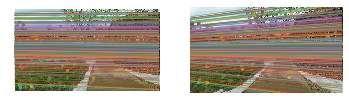

In [327]:
# Step 2: compute fundamental matrix
    F = compute_F(pts1, pts2)
    visualize_epipolar_lines(F, pts1, pts2, img_left, img_right)


In [328]:
print(F)
np.linalg.matrix_rank(F)


[[-1.57913274e-07  1.05115838e-05 -2.76882044e-03]
 [-2.27253324e-06 -6.14958932e-07 -1.91788249e-02]
 [ 3.75066502e-04  1.60172177e-02  9.99683857e-01]]


2

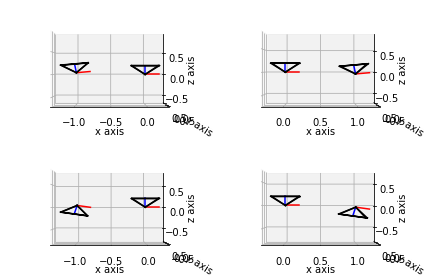

In [329]:
# Step 3: computes four sets of camera poses
    K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
    Rs, Cs = compute_camera_pose(F, K)
    visualize_camera_poses(Rs, Cs)

In [330]:
def skew(x):
    output = np.array([[0,-x[2],x[1]],
                       [x[2],0,-x[0]],
                       [-x[1],x[0],0]])
    return output
                                      

In [331]:
def triangulation(P1, P2, pts1, pts2):
    # TO DO
    pts3D=np.zeros((len(pts1),3))
    for i in range(len(pts1)):
        A1 = skew(np.append(pts1[i,:],1)) @ P1
        A2 = skew(np.append(pts2[i,:],1)) @ P2                                             
        A  = np.concatenate((A1, A2), axis=0)  
        # print(A.shape)
        # Construct A matrix
        # Solve linear least squares to get 3D point
        # X(:,i) = point_3d;
        u, s, vh = np.linalg.svd(A)
        v= vh
        #v= vh.T
        #print(A1)
        p = v[:,-1]
        #print(p)
        pts3D[i,:] = p[:3]/p[3]
        #pts3D[i,:] = p[:3]*20
    return pts3D

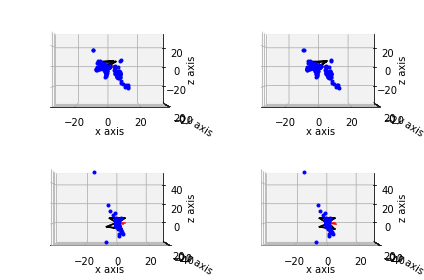

In [332]:
# Step 4: triangulation
    pts3Ds = []
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    for i in range(len(Rs)):
        P2 = K @ np.hstack((Rs[i], -Rs[i] @ Cs[i]))
        pts3D = triangulation(P1, P2, pts1, pts2)
        pts3Ds.append(pts3D)
    visualize_camera_poses_with_pts(Rs, Cs, pts3Ds)


In [333]:
def disambiguate_pose(Rs, Cs, pts3Ds):
    # TO DO
    max_sum = 0
    id_n = 0
    #pts3D = np.zeros_like(pts3Ds[0])
    #print(len(Rs),len(Cs))
    #print(Rs[0][-1:])
    #print(Cs[0])
    #print(pts3Ds[0].shape)
    for i in range(len(Rs)):
        r = np.array(Rs[i][-1,:])
        idx = (pts3Ds[i]-Cs[i].T)@r
        if len(np.where(idx>0))>max_sum:
            max_sum =len(np.where(idx>0))
            id_n = i
    R = Rs[id_n]
    C = Cs[id_n]
    pts3D = pts3Ds[id_n]
    return R, C, pts3D

In [334]:
 # Step 5: disambiguate camera poses
R, C, pts3D = disambiguate_pose(Rs, Cs, pts3Ds)
#print(pts3D)

In [335]:
def compute_rectification(K, R, C):
    # TO DO
    C = np.reshape(C, (1,3))  # make sure C is 1x3

    rx = -C / np.linalg.norm(C)
    rz_tilde = np.array([0, 0, 1])
    rz = (rz_tilde - (rz_tilde @ rx.T) @ rx)/ np.linalg.norm((rz_tilde - (rz_tilde @ rx.T) @ rx))
    rz = rz.reshape((1,3))
    ry = np.cross(rz, rx)
    
    print(rx.shape,ry.shape,rz.shape)
    R_rect = np.concatenate((rx,ry,rz), axis=0)

    H1 = K @ R_rect @ np.linalg.inv(K);
    H2 = K @ R_rect @ R.T @ np.linalg.inv(K);
    return H1, H2

(1, 3) (1, 3) (1, 3)


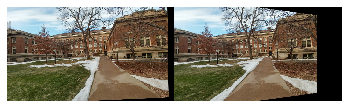

In [336]:
# Step 6: rectification
    H1, H2 = compute_rectification(K, R, C)
    img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
    img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
    visualize_img_pair(img_left_w, img_right_w)

In [337]:
print(F)
np.linalg.matrix_rank(F)
np.save("good_F_3",F)

[[-1.57913274e-07  1.05115838e-05 -2.76882044e-03]
 [-2.27253324e-06 -6.14958932e-07 -1.91788249e-02]
 [ 3.75066502e-04  1.60172177e-02  9.99683857e-01]]


In [239]:
def dense_match(img1, img2):
    # TO DO
    return disparity

In [5]:
# PROVIDED functions
def compute_camera_pose(F, K):
    E = K.T @ F @ K
    R_1, R_2, t = cv2.decomposeEssentialMat(E)
    # 4 cases
    R1, t1 = R_1, t
    R2, t2 = R_1, -t
    R3, t3 = R_2, t
    R4, t4 = R_2, -t

    Rs = [R1, R2, R3, R4]
    ts = [t1, t2, t3, t4]
    Cs = []
    for i in range(4):
        Cs.append(-Rs[i].T @ ts[i])
    return Rs, Cs


def visualize_img_pair(img1, img2):
    img = np.hstack((img1, img2))
    if img1.ndim == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


def visualize_find_match(img1, img2, pts1, pts2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    img_h = img1.shape[0]
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    pts1 = pts1 * scale_factor1
    pts2 = pts2 * scale_factor2
    pts2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect='auto')
    for i in range(pts1.shape[0]):
        plt.plot([pts1[i, 0], pts2[i, 0]], [pts1[i, 1], pts2[i, 1]], 'b.-', linewidth=0.5, markersize=5)
    plt.axis('off')
    plt.show()


def visualize_epipolar_lines(F, pts1, pts2, img1, img2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    for i in range(pts1.shape[0]):
        x1, y1 = int(pts1[i][0] + 0.5), int(pts1[i][1] + 0.5)
        ax1.scatter(x1, y1, s=5)
        p1, p2 = find_epipolar_line_end_points(img2, F, (x1, y1))
        ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    for i in range(pts2.shape[0]):
        x2, y2 = int(pts2[i][0] + 0.5), int(pts2[i][1] + 0.5)
        ax2.scatter(x2, y2, s=5)
        p1, p2 = find_epipolar_line_end_points(img1, F.T, (x2, y2))
        ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    ax1.axis('off')
    ax2.axis('off')
    plt.show()


def find_epipolar_line_end_points(img, F, p):
    img_width = img.shape[1]
    el = np.dot(F, np.array([p[0], p[1], 1]).reshape(3, 1))
    p1, p2 = (0, -el[2] / el[1]), (img.shape[1], (-img_width * el[0] - el[2]) / el[1])
    _, p1, p2 = cv2.clipLine((0, 0, img.shape[1], img.shape[0]), p1, p2)
    return p1, p2


def visualize_camera_poses(Rs, Cs):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2 = Rs[i], Cs[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1)
        draw_camera(ax, R2, C2)
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
    fig.tight_layout()
    plt.show()


def visualize_camera_poses_with_pts(Rs, Cs, pts3Ds):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2, pts3D = Rs[i], Cs[i], pts3Ds[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1, 5)
        draw_camera(ax, R2, C2, 5)
        ax.plot(pts3D[:, 0], pts3D[:, 1], pts3D[:, 2], 'b.')
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
    fig.tight_layout()
    plt.show()


def draw_camera(ax, R, C, scale=0.2):
    axis_end_points = C + scale * R.T  # (3, 3)
    vertices = C + scale * R.T @ np.array([[1, 1, 1], [-1, 1, 1], [-1, -1, 1], [1, -1, 1]]).T  # (3, 4)
    vertices_ = np.hstack((vertices, vertices[:, :1]))  # (3, 5)

    # draw coordinate system of camera
    ax.plot([C[0], axis_end_points[0, 0]], [C[1], axis_end_points[1, 0]], [C[2], axis_end_points[2, 0]], 'r-')
    ax.plot([C[0], axis_end_points[0, 1]], [C[1], axis_end_points[1, 1]], [C[2], axis_end_points[2, 1]], 'g-')
    ax.plot([C[0], axis_end_points[0, 2]], [C[1], axis_end_points[1, 2]], [C[2], axis_end_points[2, 2]], 'b-')

    # draw square window and lines connecting it to camera center
    ax.plot(vertices_[0, :], vertices_[1, :], vertices_[2, :], 'k-')
    ax.plot([C[0], vertices[0, 0]], [C[1], vertices[1, 0]], [C[2], vertices[2, 0]], 'k-')
    ax.plot([C[0], vertices[0, 1]], [C[1], vertices[1, 1]], [C[2], vertices[2, 1]], 'k-')
    ax.plot([C[0], vertices[0, 2]], [C[1], vertices[1, 2]], [C[2], vertices[2, 2]], 'k-')
    ax.plot([C[0], vertices[0, 3]], [C[1], vertices[1, 3]], [C[2], vertices[2, 3]], 'k-')


def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
    y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
    z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


def visualize_disparity_map(disparity):
    plt.imshow(disparity, cmap='jet')
    plt.show()

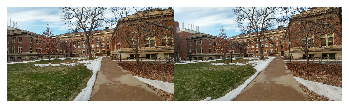

ValueError: too many values to unpack (expected 2)

In [160]:
if __name__ == '__main__':
    # read in left and right images as RGB images
    img_left = cv2.imread('./left.bmp', 1)
    img_right = cv2.imread('./right.bmp', 1)
    visualize_img_pair(img_left, img_right)

    # Step 1: find correspondences between image pair
    pts1, pts2 = find_match(img_left, img_right)
    visualize_find_match(img_left, img_right, pts1, pts2)


In [ ]:

    # Step 2: compute fundamental matrix
    F = compute_F(pts1, pts2)
    visualize_epipolar_lines(F, pts1, pts2, img_left, img_right)

    # Step 3: computes four sets of camera poses
    K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
    Rs, Cs = compute_camera_pose(F, K)
    visualize_camera_poses(Rs, Cs)

    # Step 4: triangulation
    pts3Ds = []
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    for i in range(len(Rs)):
        P2 = K @ np.hstack((Rs[i], -Rs[i] @ Cs[i]))
        pts3D = triangulation(P1, P2, pts1, pts2)
        pts3Ds.append(pts3D)
    visualize_camera_poses_with_pts(Rs, Cs, pts3Ds)

    # Step 5: disambiguate camera poses
    R, C, pts3D = disambiguate_pose(Rs, Cs, pts3Ds)

    # Step 6: rectification
    H1, H2 = compute_rectification(K, R, C)
    img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
    img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
    visualize_img_pair(img_left_w, img_right_w)

    # Step 7: generate disparity map
    img_left_w = cv2.resize(img_left_w, (int(img_left_w.shape[1] / 2), int(img_left_w.shape[0] / 2)))  # resize image for speed
    img_right_w = cv2.resize(img_right_w, (int(img_right_w.shape[1] / 2), int(img_right_w.shape[0] / 2)))
    img_left_w = cv2.cvtColor(img_left_w, cv2.COLOR_BGR2GRAY)  # convert to gray scale
    img_right_w = cv2.cvtColor(img_right_w, cv2.COLOR_BGR2GRAY)
    disparity = dense_match(img_left_w, img_right_w)
    visualize_disparity_map(disparity)

    # save to mat
    sio.savemat('stereo.mat', mdict={'pts1': pts1, 'pts2': pts2, 'F': F, 'pts3D': pts3D, 'H1': H1, 'H2': H2,
                                     'img_left_w': img_left_w, 'img_right_w': img_right_w, 'disparity': disparity})
